In [ ]:
import os
print("CPU 논리 코어 수:", os.cpu_count())


CPU 논리 코어 수: 11


In [3]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianNoised,
    ToTensord, RandCropByLabelClassesd
)
from src.dataset.dataset import create_dataloaders


In [ ]:
from CSANet.CSANet.networks.vit_seg_modeling import VisionTransformer as ViT_seg
from CSANet.CSANet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
from monai.losses import TverskyLoss
from pathlib import Path

# Model Configuration
vit_name = 'R50-ViT-B_16'
config_vit = CONFIGS_ViT_seg[vit_name]
config_vit.n_classes = 7  # Your number of classes
config_vit.n_skip = 3
vit_patches_size = 16
img_size = vit_patches_size * 6  # Match your patch size
batch_size = 64 # 13.8GB GPU memory required for 128x128 img size
num_samples = 8
loader_batch = num_samples//num_samples
# Training setup
num_epochs = 300
lamda = 0.15
lr = 0.001

train_img_dir = "./datasets/train/images"
train_label_dir = "./datasets/train/labels"
val_img_dir = "./datasets/val/images"
val_label_dir = "./datasets/val/labels"

non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[5, 96, 96],
        num_classes=7,
        num_samples=num_samples  # num_samples 값을 양의 정수로 설정
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1,2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])
train_loader, val_loader = create_dataloaders(train_img_dir, train_label_dir, val_img_dir, val_label_dir, non_random_transforms,random_transforms,batch_size,loader_batch)
# Initialize model
config_vit.patches.grid = (int(img_size / vit_patches_size), int(img_size / vit_patches_size))
model = ViT_seg(config_vit, img_size=img_size, num_classes=config_vit.n_classes)
model.cuda()

# Load pretrained weights
# model.load_from(weights=np.load(config_vit.real_pretrained_path, allow_pickle=True))

# optimizer = optim.AdamW(model.parameters(), lr=lr)

# TverskyLoss 설정
criterion = TverskyLoss(
    alpha=lamda,  # FP에 대한 가중치
    beta=1-lamda,   # FN에 대한 가중치
    include_background=True,
    softmax=True
)

# 체크포인트 저장 디렉토리 설정
checkpoint_base_dir = Path("./model_checkpoints")
checkpoint_dir = checkpoint_base_dir / f"memmap_all_img{img_size}_lr{lr}_lambda{lamda}_batch{batch_size}"

# 체크포인트 디렉토리가 있고 best_model.pt가 존재하면 로드
if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        model.load_state_dict(torch.load(best_model_path))
        print("기존 학습된 가중치를 성공적으로 로드했습니다.")
    else:
        print("새로운 학습을 시작합니다.")
        model.load_from(weights=np.load(config_vit.real_pretrained_path, allow_pickle=True))
else:
    print("새로운 학습을 시작합니다.")
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    model.load_from(weights=np.load(config_vit.real_pretrained_path, allow_pickle=True))

optimizer = optim.AdamW(model.parameters(), lr=lr)


def initialize_model(vit_name, num_classes, img_size, pretrained_path):
    config_vit = CONFIGS_ViT_seg[vit_name]
    config_vit.n_classes = num_classes
    config_vit.n_skip = 3
    config_vit.patches.grid = (int(img_size / config_vit.patches.size), int(img_size / config_vit.patches.size))
    model = ViT_seg(config_vit, img_size=img_size, num_classes=config_vit.n_classes)
    model.cuda()
    model.load_from(weights=np.load(pretrained_path, allow_pickle=True))
    return model, config_vit

def train_one_epoch(model, train_loader, criterion, optimizer, config_vit):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, desc='Training') as pbar:
        for batch_data in pbar:
            images = batch_data['image'].cuda()
            labels = batch_data['label'].cuda()
            
            if images.shape[2] == 96:
                images = images.permute(0, 1, 4, 2, 3)
                labels = labels.permute(0, 1, 4, 2, 3)
                
            center = images.shape[2] // 2
            prev_image = images[:, :, 0:center, :, :]
            image = images[:, :, center:center+1, :, :]
            next_image = images[:, :, center+1:, :, :]
            
            prev_image = prev_image.squeeze(2)
            image = image.squeeze(2)
            next_image = next_image.squeeze(2)
            
            labels = labels.squeeze(1)
            labels = labels.long()
            labels_onehot = torch.nn.functional.one_hot(labels, num_classes=config_vit.n_classes)
            labels_onehot = labels_onehot.permute(0, 3, 1, 2).float()

            optimizer.zero_grad()
            outputs = model(prev_image, image, next_image)
            loss = criterion(outputs, labels_onehot)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
    
    return epoch_loss / len(train_loader)

def validate_one_epoch(model, val_loader, criterion, config_vit):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        with tqdm(val_loader, desc='Validation') as pbar:
            for batch_data in pbar:
                images = batch_data['image'].cuda()
                labels = batch_data['label'].cuda()
                
                if images.shape[2] == 96:
                    images = images.permute(0, 1, 4, 2, 3)
                    labels = labels.permute(0, 1, 4, 2, 3)
                    
                center = images.shape[2] // 2
                prev_image = images[:, :, 0:center, :, :]
                image = images[:, :, center:center+1, :, :]
                next_image = images[:, :, center+1:, :, :]
                
                prev_image = prev_image.squeeze(2)
                image = image.squeeze(2)
                next_image = next_image.squeeze(2)
                
                labels = labels.squeeze(1)
                labels = labels.long()
                labels_onehot = torch.nn.functional.one_hot(labels, num_classes=config_vit.n_classes)
                labels_onehot = labels_onehot.permute(0, 3, 1, 2).float()

                outputs = model(prev_image, image, next_image)
                loss = criterion(outputs, labels_onehot)
                
                val_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
    
    return val_loss / len(val_loader)

def train_model(model, train_loader, val_loader, criterion, optimizer, config_vit, num_epochs, patience):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, config_vit)
        val_loss = validate_one_epoch(model, val_loader, criterion, config_vit)
        
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # 모델 저장 (필요한 경우)
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

train_model(model, train_loader, val_loader, criterion, optimizer, config_vit, num_epochs, patience=10)


새로운 학습을 시작합니다.
load_pretrained: grid-size from 14 to 6
Epoch 1/300


Validation: 100%|██████████| 558/558 [02:46<00:00,  3.35it/s, loss=3.48e-6]


Training Loss: 0.2043, Validation Loss: 0.0686
Epoch 2/300


Validation: 100%|██████████| 558/558 [02:34<00:00,  3.61it/s, loss=1.29e-6]


Training Loss: 0.0546, Validation Loss: 0.0686
Epoch 3/300


Validation: 100%|██████████| 558/558 [02:34<00:00,  3.61it/s, loss=2.98e-7]


Training Loss: 0.0546, Validation Loss: 0.0686
Epoch 4/300


Validation: 100%|██████████| 558/558 [02:45<00:00,  3.37it/s, loss=6.95e-8]


Training Loss: 0.0546, Validation Loss: 0.0686
Epoch 5/300


Validation: 100%|██████████| 558/558 [02:35<00:00,  3.60it/s, loss=0]      


Training Loss: 0.0546, Validation Loss: 0.0686
Epoch 6/300


Validation: 100%|██████████| 558/558 [02:34<00:00,  3.61it/s, loss=0]      


Training Loss: 0.0546, Validation Loss: 0.0686
Epoch 7/300


Validation: 100%|██████████| 558/558 [02:35<00:00,  3.59it/s, loss=0]      


Training Loss: 0.0545, Validation Loss: 0.0686
Epoch 8/300


Validation: 100%|██████████| 558/558 [02:34<00:00,  3.61it/s, loss=0]      


Training Loss: 0.0546, Validation Loss: 0.0686
Epoch 9/300


Validation: 100%|██████████| 558/558 [02:34<00:00,  3.60it/s, loss=0]      


Training Loss: 0.0546, Validation Loss: 0.0686
Epoch 10/300


Validation:  18%|█▊        | 101/558 [00:31<02:13,  3.43it/s, loss=0.045] 

In [ ]:
from CSANet.CSANet.networks.vit_seg_modeling import VisionTransformer as ViT_seg
from CSANet.CSANet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from pathlib import Path
import numpy as np
import torch
from scipy import ndimage
from typing import List, Dict, Tuple
from tqdm import tqdm

def get_center_points(label_map: np.ndarray, crop_info: Dict, exclude_class: int = 2) -> List[Dict]:
    """객체 중심점 추출 (class 1 제외)"""
    centers = []
    
    for class_id in np.unique(label_map):
        # class 1 제외
        if class_id == 0 or class_id == exclude_class:
            continue
            
        # 현재 클래스에 대한 바이너리 마스크
        class_mask = label_map == class_id
        labeled_array, num_features = ndimage.label(class_mask)
        
        # 각 객체의 중심점 계산
        for label_id in range(1, num_features + 1):
            object_mask = labeled_array == label_id
            coords = np.array(np.nonzero(object_mask))  # [num_dims, N]
            
            if coords.size > 0:
                # 3D 데이터의 경우 3개의 좌표가 있을 수 있으므로 차원 확인
                if coords.shape[0] == 2:  # 2D case
                    y, x = coords.mean(axis=1)
                else:  # 3D case or other
                    coord_means = coords.mean(axis=1)
                    y, x = coord_means[-2:]  # 마지막 두 차원을 y, x로 사용
                
                # crop 좌표를 원본 좌표로 변환
                orig_x = x + crop_info['x_start']
                orig_y = y + crop_info['y_start']
                orig_z = crop_info['z_center']
                
                centers.append({
                    'x': float(orig_x),
                    'y': float(orig_y),
                    'z': float(orig_z),
                    'class': int(class_id)
                })
    
    return centers

def calculate_distance(point1: Dict, point2: Dict) -> float:
    """두 점 사이의 유클리드 거리"""
    return np.sqrt(
        (point1['x'] - point2['x'])**2 + 
        (point1['y'] - point2['y'])**2 + 
        (point1['z'] - point2['z'])**2
    )

def calculate_fbeta_score(pred_centers: List[Dict], 
                         gt_centers: List[Dict], 
                         distance_threshold: float = 10.0,
                         beta: float = 4.0) -> float:
    """F-beta score 계산 (beta=4)"""
    if len(pred_centers) == 0 and len(gt_centers) == 0:
        return 1.0
    if len(pred_centers) == 0 or len(gt_centers) == 0:
        return 0.0
    
    # 거리 행렬 계산
    distances = np.zeros((len(pred_centers), len(gt_centers)))
    for i, pred in enumerate(pred_centers):
        for j, gt in enumerate(gt_centers):
            # 같은 클래스인 경우에만 매칭
            if pred['class'] == gt['class']:
                distances[i, j] = calculate_distance(pred, gt)
            else:
                distances[i, j] = float('inf')
    
    # 매칭 및 점수 계산
    true_positives = 0
    matched_gt = set()
    
    for i in range(len(pred_centers)):
        if np.min(distances[i]) > distance_threshold:
            continue
            
        min_dist_idx = np.argmin(distances[i])
        if min_dist_idx not in matched_gt:
            true_positives += 1
            matched_gt.add(min_dist_idx)
    
    precision = true_positives / len(pred_centers) if len(pred_centers) > 0 else 0
    recall = true_positives / len(gt_centers) if len(gt_centers) > 0 else 0
    
    # F-beta 계산
    beta_square = beta ** 2
    if precision == 0 and recall == 0:
        return 0.0
    fbeta = (1 + beta_square) * (precision * recall) / (beta_square * precision + recall)
    
    return fbeta

def test_segmentation(model, test_loader, device, config_vit):
    """테스트 및 평가"""
    model.eval()
    results = []
    total_score = 0
    num_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 데이터 준비
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            crop_info = batch['crop_info']
            
            # # crop_info 디버깅
            # print("Crop info keys:", crop_info.keys())
            # for k, v in crop_info.items():
            #     print(f"{k}: type={type(v)}, shape/len={v.shape if torch.is_tensor(v) else len(v) if hasattr(v, '__len__') else 'scalar'}")
            
            # 2.5D 입력 준비
            prev_image = images[:, :, 0:1, :, :].squeeze(2)
            curr_image = images[:, :, 1:2, :, :].squeeze(2)
            next_image = images[:, :, 2:3, :, :].squeeze(2)
            
            # 추론
            outputs = model(prev_image, curr_image, next_image)
            pred = torch.argmax(outputs, dim=1)  # (B, H, W)
            
            # 배치의 각 샘플에 대해 처리
            for i in range(pred.size(0)):
                try:
                    # crop_info 처리
                    batch_crop_info = {}
                    for k, v in crop_info.items():
                        if torch.is_tensor(v):
                            batch_crop_info[k] = v[i].item()
                        elif isinstance(v, (list, tuple)) and len(v) > i:
                            batch_crop_info[k] = v[i]
                        else:
                            batch_crop_info[k] = v
                    
                    # 예측 및 정답 라벨에서 중심점 추출
                    pred_centers = get_center_points(
                        pred[i].cpu().numpy(), 
                        batch_crop_info
                    )
                    gt_centers = get_center_points(
                        labels[i].cpu().numpy(),
                        batch_crop_info
                    )
                    
                    # F-beta score 계산
                    score = calculate_fbeta_score(pred_centers, gt_centers, beta=4.0)
                    
                    results.append({
                        'file_name': batch_crop_info.get('file_name', f'sample_{num_samples}'),
                        'pred_centers': pred_centers,
                        'gt_centers': gt_centers,
                        'score': score
                    })
                    
                    total_score += score
                    num_samples += 1
                    
                except Exception as e:
                    print(f"Error processing sample {i}: {str(e)}")
                    continue
    
    avg_score = total_score / num_samples if num_samples > 0 else 0
    print(f"\n평균 F4-score: {avg_score:.4f}")
    
    return results

def load_best_model(model, checkpoint_dir: str = "./model_checkpoints"):
    """베스트 모델 가중치 로드"""
    checkpoint_path = Path(checkpoint_dir) / 'best_model.pt'  # .pth에서 .pt로 변경
    
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"베스트 모델을 찾을 수 없습니다: {checkpoint_path}")
    
    print(f"베스트 모델 로드 중: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
    model = model.cuda()
    model.eval()
    
    return model

# 사용 예시
model = ViT_seg(config_vit, img_size=img_size, num_classes=config_vit.n_classes)
model = load_best_model(model, checkpoint_dir=checkpoint_dir)

# 테스트 실행
if __name__ == "__main__":
    # self_test용 데이터셋 생성
    test_ds = CryoET_2_5D_Dataset(
        data_dir="./datasets",
        mode='self_test',  # 경로 변경
        slice_depth=3,
        crop_size=(img_size, img_size),
        transform=None  # 테스트시에는 transform 없음
    )
    
    # DataLoader 설정
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,  # 테스트시에는 shuffle 없음
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 결과 디렉토리 생성
    save_dir = checkpoint_dir / "results"
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # 테스트 실행 및 결과 저장
    results = test_segmentation(model, test_loader, device, config_vit)
    np.save(save_dir / "test_results.npy", results)

Testing: 0it [00:00, ?it/s]


평균 F4-score: 0.0000


C:\Users\pook0\AppData\Local\Temp\ipykernel_26412\4075414228.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


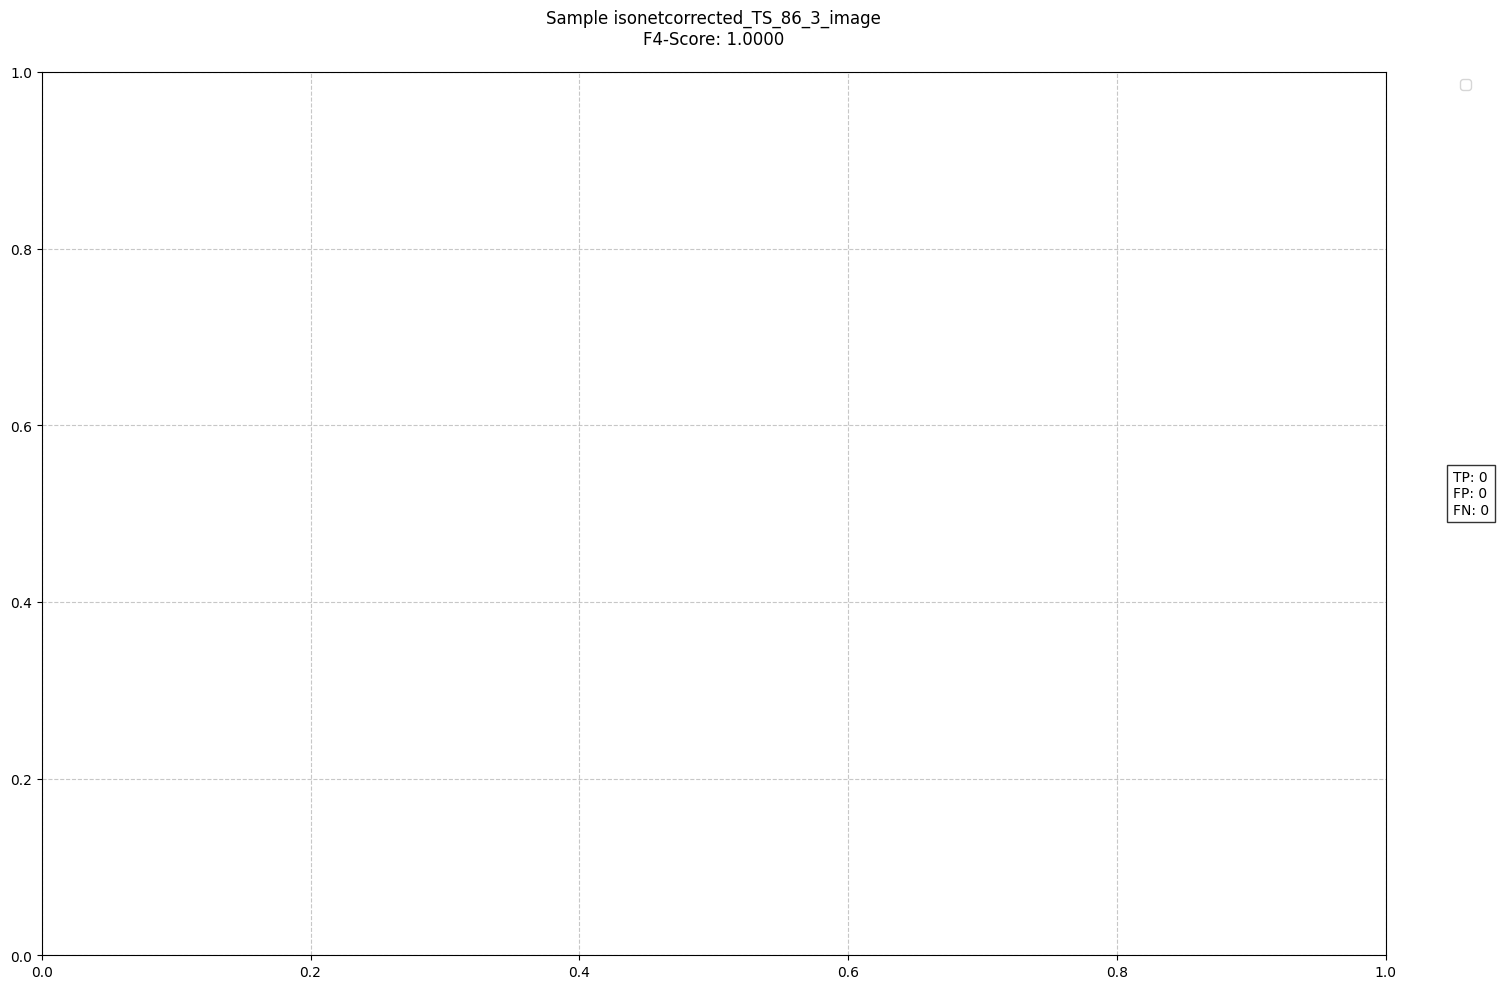

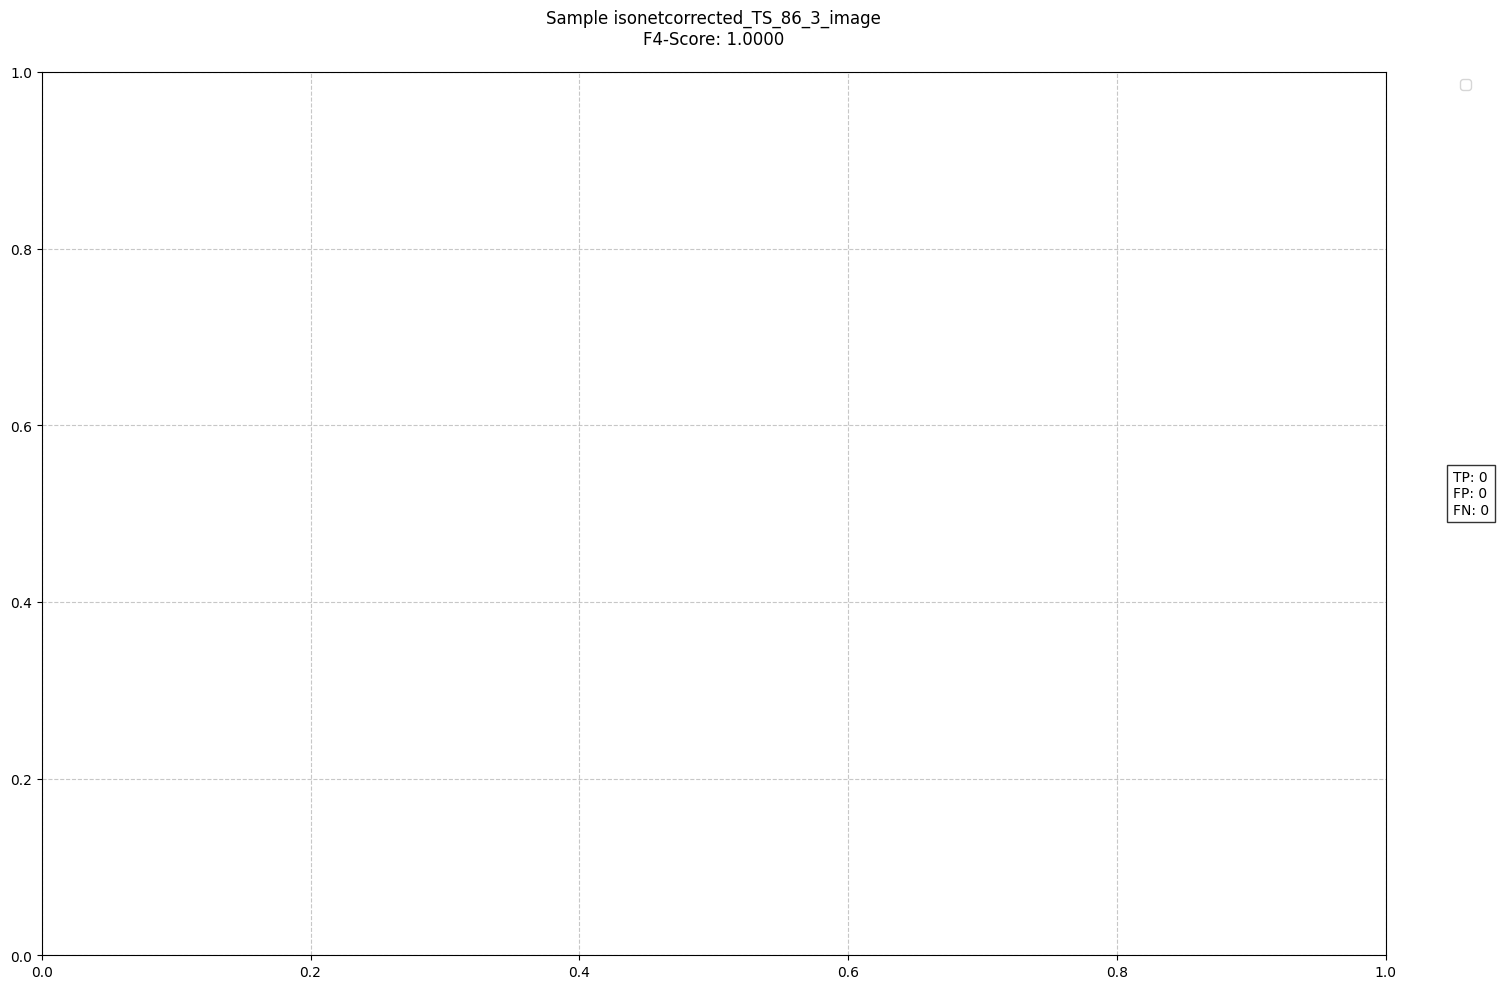

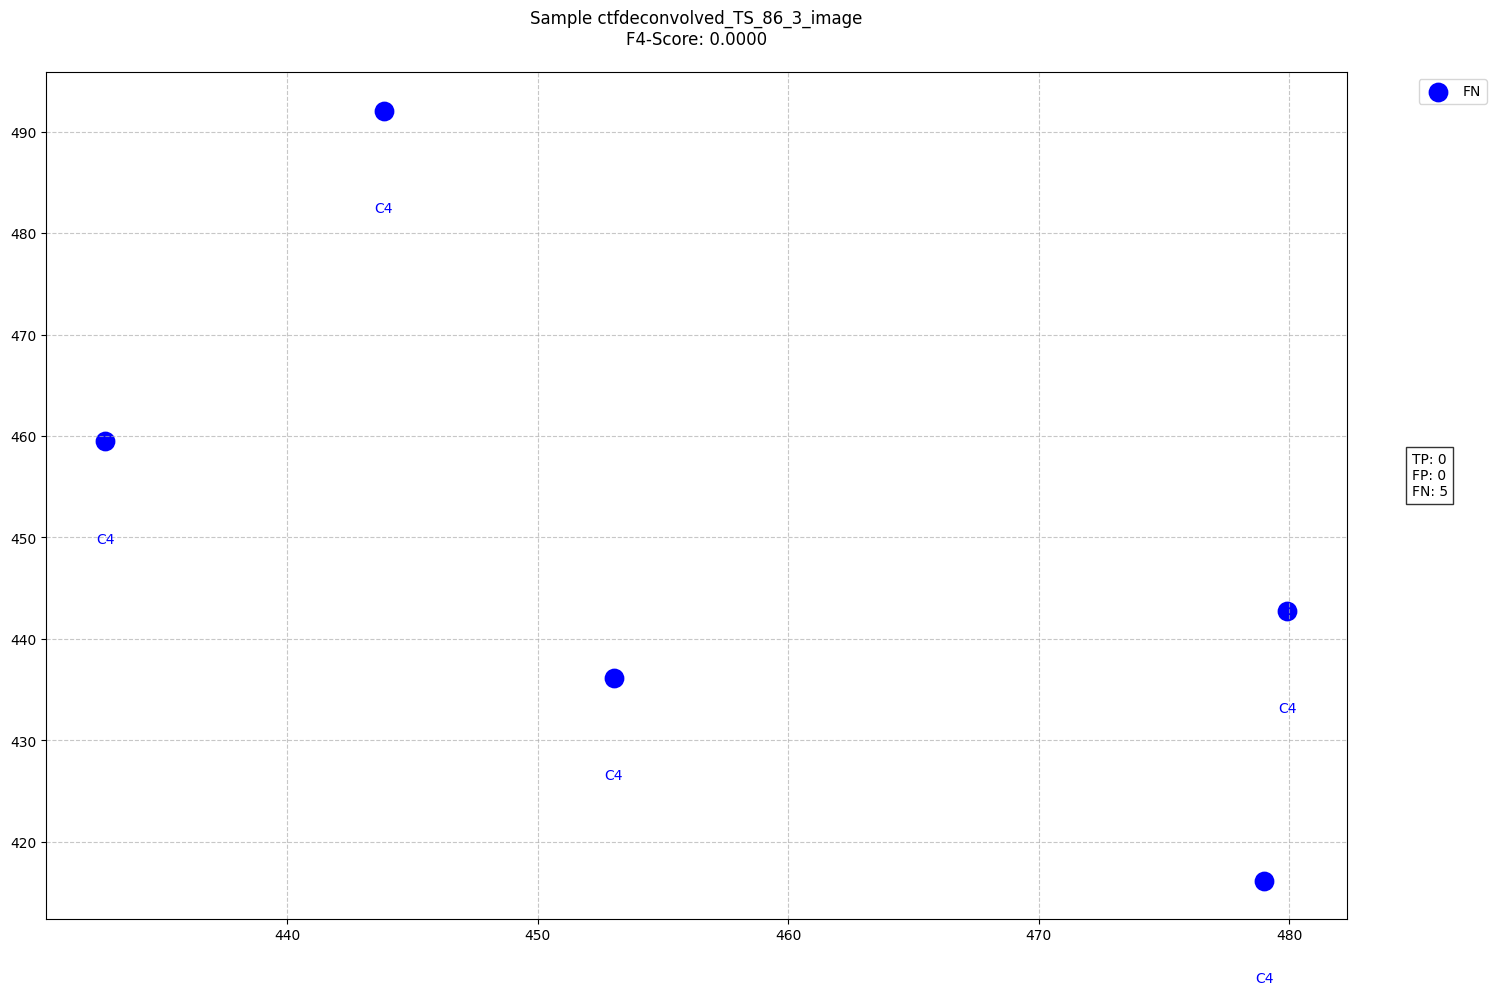

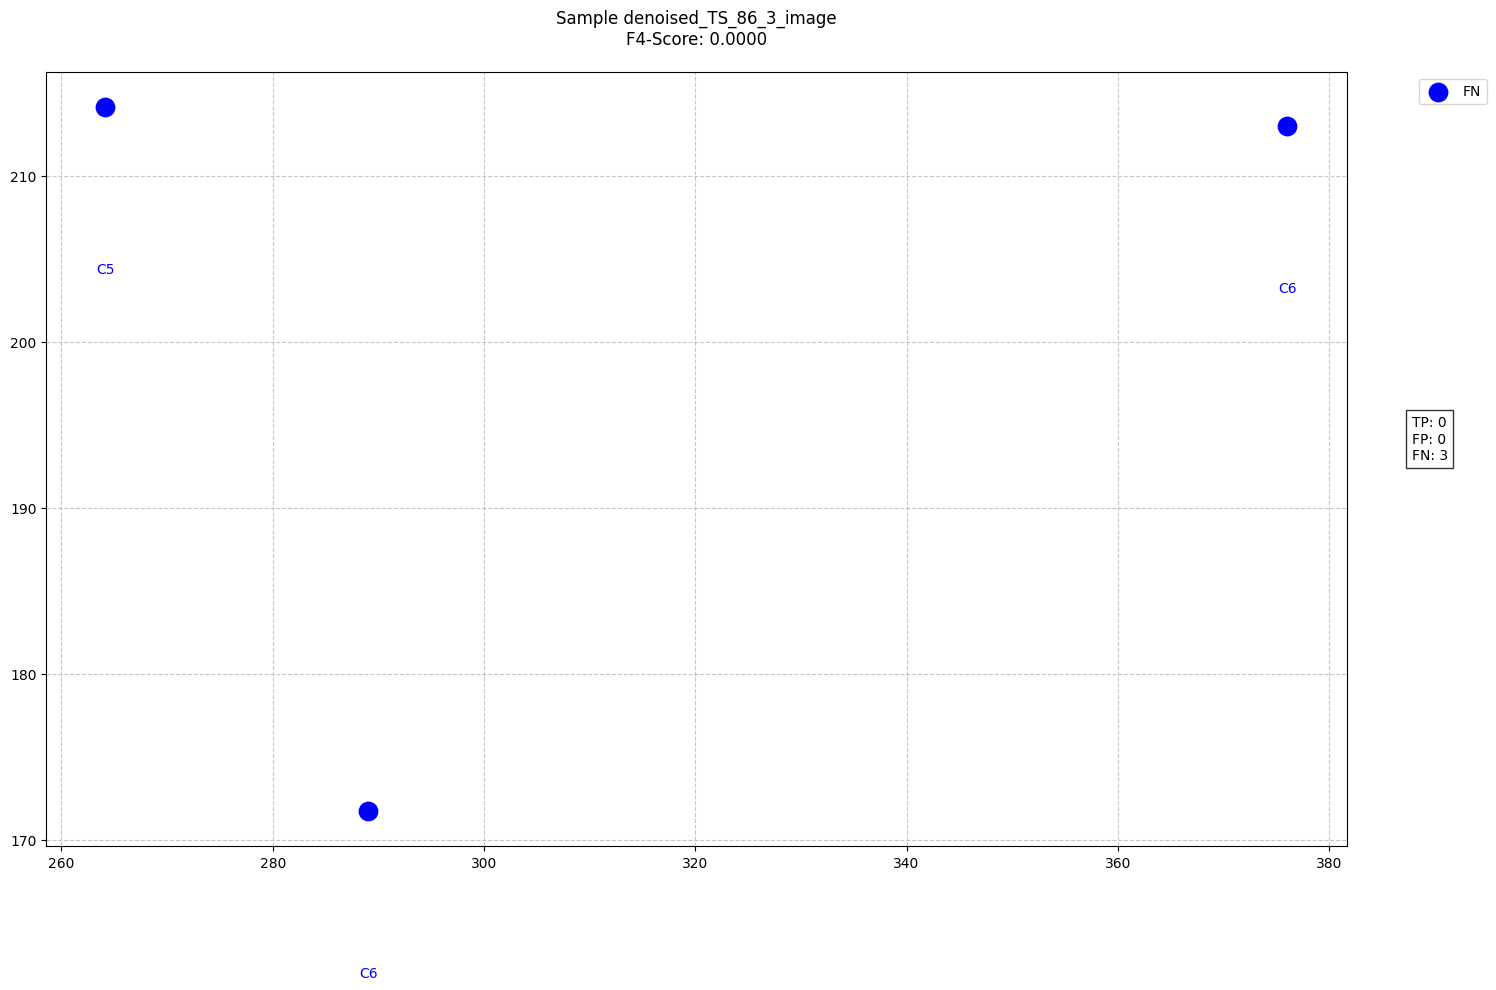

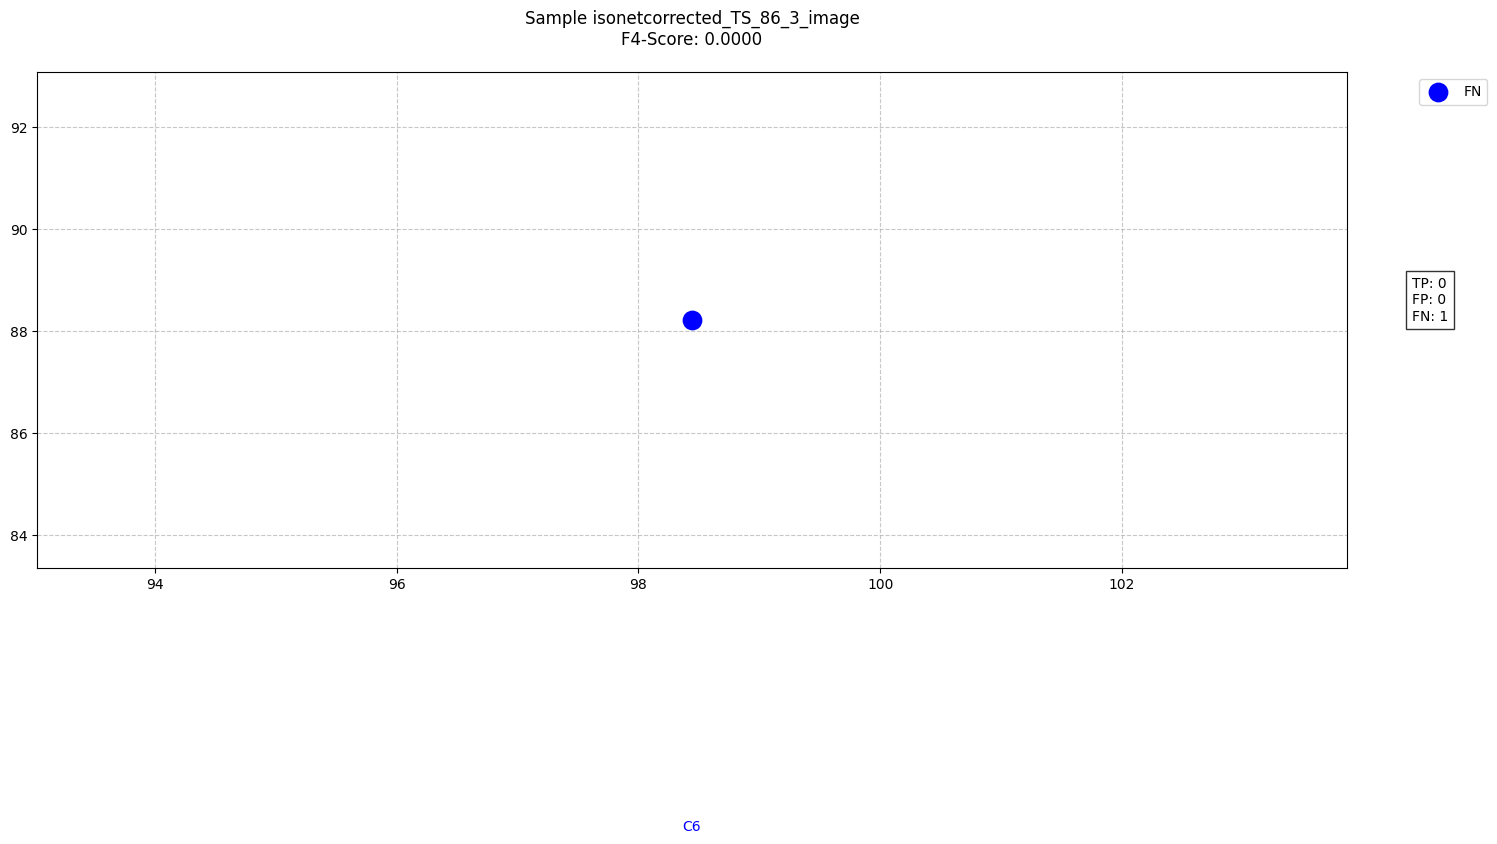


=== 결과 통계 ===
평균 F4-score: 0.5921
최대 F4-score: 1.0000
최소 F4-score: 0.0000


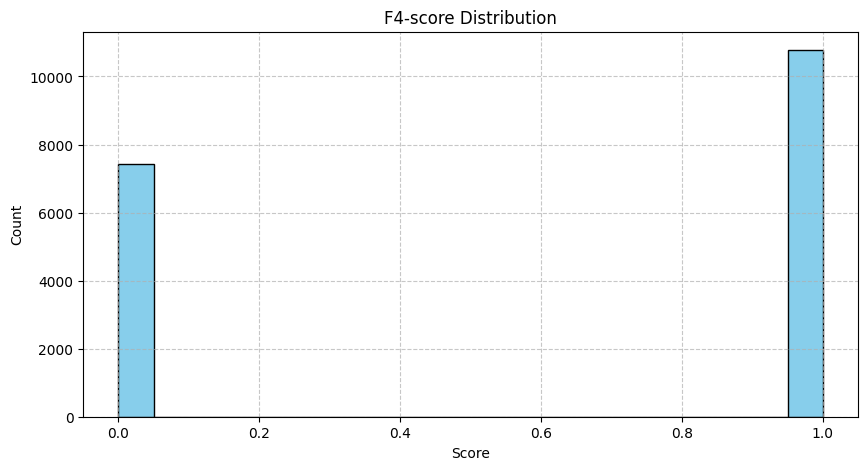

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch

def categorize_predictions(pred_centers, gt_centers, distance_threshold=10.0):
    """예측을 TP, FP, FN으로 분류"""
    tp_pred = []
    fp_pred = []
    fn_gt = gt_centers.copy()
    
    # TP와 FP 찾기
    for pred in pred_centers:
        matched = False
        for gt in gt_centers:
            if pred['class'] == gt['class']:
                dist = np.sqrt(
                    (pred['x'] - gt['x'])**2 + 
                    (pred['y'] - gt['y'])**2 + 
                    (pred['z'] - gt['z'])**2
                )
                if dist <= distance_threshold:
                    tp_pred.append(pred)
                    fn_gt.remove(gt)  # matched GT 제거
                    matched = True
                    break
        if not matched:
            fp_pred.append(pred)
            
    return tp_pred, fp_pred, fn_gt

def visualize_results(results_path: str = "./results/test_results.npy", num_samples: int = 5):
    """테스트 결과 시각화"""
    results = np.load(results_path, allow_pickle=True)
    indices = np.random.choice(len(results), min(num_samples, len(results)), replace=False)
    
    for idx in indices:
        result = results[idx]
        
        # TP, FP, FN 분류
        tp_pred, fp_pred, fn_gt = categorize_predictions(
            result['pred_centers'], 
            result['gt_centers']
        )
        
        # 그림 설정
        plt.figure(figsize=(15, 10))
        
        # 결과 시각화
        plt.title(f"Sample {result['file_name']}\nF4-Score: {result['score']:.4f}", pad=20)
        
        # True Positives (녹색 X)
        for center in tp_pred:
            plt.scatter(center['x'], center['y'], c='g', marker='x', s=150, 
                       label='TP' if center == tp_pred[0] else "", linewidth=2)
            plt.text(center['x'], center['y']+5, f"C{center['class']}", 
                    color='g', fontsize=10, ha='center')
        
        # False Positives (빨간색 X)
        for center in fp_pred:
            plt.scatter(center['x'], center['y'], c='r', marker='x', s=150, 
                       label='FP' if center == fp_pred[0] else "", linewidth=2)
            plt.text(center['x'], center['y']+5, f"C{center['class']}", 
                    color='r', fontsize=10, ha='center')
        
        # False Negatives (파란색 원)
        for center in fn_gt:
            plt.scatter(center['x'], center['y'], c='b', marker='o', s=150, 
                       label='FN' if center == fn_gt[0] else "", facecolors='none', linewidth=2)
            plt.text(center['x'], center['y']-10, f"C{center['class']}", 
                    color='b', fontsize=10, ha='center')
        
        # 범례 및 그리드
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 통계 텍스트 추가
        stats_text = f"TP: {len(tp_pred)}\nFP: {len(fp_pred)}\nFN: {len(fn_gt)}"
        plt.text(1.05, 0.5, stats_text, transform=plt.gca().transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    # 전체 통계
    scores = [r['score'] for r in results]
    print(f"\n=== 결과 통계 ===")
    print(f"평균 F4-score: {np.mean(scores):.4f}")
    print(f"최대 F4-score: {np.max(scores):.4f}")
    print(f"최소 F4-score: {np.min(scores):.4f}")
    
    # Score 분포 히스토그램
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("F4-score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

if __name__ == "__main__":
    visualize_results(results_path=save_dir / "test_results.npy", num_samples=5)